In [1]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main'

In [2]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main'

In [3]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main'

### Second Software Design and Nueral Network
    1. Understanding and importing both datasets
    2. Designing the neural network with tasks

    3. Adding object detection within the the first model
        Adding in the lane segmentation print out for the picture.

    4. Set up infrastructure for weights and understanding how we are going to make the print out on the FPGA
    

In [5]:
#1. Import Necessary Liobraries
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, AveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1


from keras.optimizers import Adam
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp


### SIGNS Dataset Import / transform

In [7]:
#2. Import the Signs Dataset
##  Baron's Path
signs_dataset = r"C:\Users\Baron\Documents\Grad_School\EE_297A\Project\datasets\signs"
lanes_dataset = r"Z:\EE_297A\dataset\lanes"


# Define your target classes
target_classes = [0, 1, 9, 12, 13, 14, 17, 26, 27, 28]

# Map each class to an index: 0–9
class_id_to_index = {class_id: idx for idx, class_id in enumerate(target_classes)}

signs_df = pd.read_csv(f"{signs_dataset}/Train.csv", delimiter = ",")

# Filter to only desired classes
signs_df = signs_df[signs_df["ClassId"].isin(target_classes)]

# Construct full file paths (without moving/copying any image)
signs_df["full_path"] = signs_df["Path"].apply(lambda p: os.path.join(signs_dataset, p))

# Apply to your DataFrame
signs_df["LabelIndex"] = signs_df["ClassId"].map(class_id_to_index)


In [8]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class SignDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "full_path"]
        label = int(self.df.loc[idx, "LabelIndex"])
        
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Use ImageNet normalization for ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create dataset and loader
sign_dataset = SignDataset(signs_df, transform=transform)
sign_loader = DataLoader(sign_dataset, batch_size=32, shuffle=True)

### LANES Dataet import transform

In [68]:
### Import the lanes dataset
import json
import pandas as pd

DATASET_DIR = r"Z:\EE_297A\dataset\lanes\TUSimple\train_set"
#TRAIN_IMAGES_DIR = os.path.join(DATASET_DIR, 'clips')
TRAIN_IMAGES_DIR = DATASET_DIR

LABELS_FILE = [
    os.path.join(DATASET_DIR, "label_data_0313.json"),
    os.path.join(DATASET_DIR, "label_data_0531.json"),
    os.path.join(DATASET_DIR, "label_data_0601.json"),
]

print(f"Train Images Path: {TRAIN_IMAGES_DIR}")
print(f"Labels Path: {LABELS_FILE}")

Train Images Path: Z:\EE_297A\dataset\lanes\TUSimple\train_set
Labels Path: ['Z:\\EE_297A\\dataset\\lanes\\TUSimple\\train_set\\label_data_0313.json', 'Z:\\EE_297A\\dataset\\lanes\\TUSimple\\train_set\\label_data_0531.json', 'Z:\\EE_297A\\dataset\\lanes\\TUSimple\\train_set\\label_data_0601.json']


In [70]:
import json

labels = []
for label_path in LABELS_FILE:
    with open(label_path, 'r') as f:
        for line in f:
            labels.append(json.loads(line))

print(f"Total labels loaded: {len(labels)}")
print("First label example:")
print(labels[0])

Total labels loaded: 3626
First label example:
{'lanes': [[-2, -2, -2, -2, 632, 625, 617, 609, 601, 594, 586, 578, 570, 563, 555, 547, 539, 532, 524, 516, 508, 501, 493, 485, 477, 469, 462, 454, 446, 438, 431, 423, 415, 407, 400, 392, 384, 376, 369, 361, 353, 345, 338, 330, 322, 314, 307, 299], [-2, -2, -2, -2, 719, 734, 748, 762, 777, 791, 805, 820, 834, 848, 863, 877, 891, 906, 920, 934, 949, 963, 978, 992, 1006, 1021, 1035, 1049, 1064, 1078, 1092, 1107, 1121, 1135, 1150, 1164, 1178, 1193, 1207, 1221, 1236, 1250, 1265, -2, -2, -2, -2, -2], [-2, -2, -2, -2, -2, 532, 503, 474, 445, 416, 387, 358, 329, 300, 271, 241, 212, 183, 154, 125, 96, 67, 38, 9, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], [-2, -2, -2, 781, 822, 862, 903, 944, 984, 1025, 1066, 1107, 1147, 1188, 1229, 1269, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2]], 'h_samples': [240, 250, 260, 

In [72]:
missing_paths = []
for item in labels:
    img_path = os.path.join(TRAIN_IMAGES_DIR, item['raw_file'])
    if not os.path.exists(img_path):
        missing_paths.append(img_path)

print(f"Missing images: {len(missing_paths)}")
for path in missing_paths[:5]:
    print("Missing:", path)

Missing images: 0


In [143]:
import cv2

class TuSimpleSegDataset(Dataset):
    def __init__(self, labels, img_dir, mask_dir, transform=None):
        self.labels = labels
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = self.labels[idx]
        
        # Load input image
        img_path = os.path.join(self.img_dir, item['raw_file'])
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Build mask path from raw_file
        mask_rel_path = item['raw_file'].replace("clips", "seg_label").replace(".jpg", ".png")
        mask_path = os.path.join(self.mask_dir, mask_rel_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask not found: {mask_path}")
        mask = mask.astype(np.float32) / 255.0  # Normalize to 0.0–1.0

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, torch.tensor(0), mask.unsqueeze(0).float()  # (3,H,W), dummy label, (1,H,W)



In [145]:
TRAIN_IMAGES_DIR = r"Z:\EE_297A\dataset\lanes\TUSimple\train_set"
TRAIN_MASKS_DIR = r"Z:\EE_297A\dataset\lanes\TUSimple\train_set"

In [103]:
train_transform = A.Compose([
    A.Resize(360, 640),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(360, 640),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

### Model Creation

In [147]:
# Split into train/val manually (for now small set)
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

# 80% train, 20% validation split
train_indices, val_indices = train_test_split(
    list(range(len(sign_dataset))), test_size=0.2, random_state=42)

train_subset = Subset(sign_dataset, train_indices)
val_subset = Subset(sign_dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

##-----------------------------------------------------------------
# Shuffle and split the full label list
train_labels, val_labels = train_test_split(labels, test_size=0.1, random_state=42)

lane_dataset = TuSimpleSegDataset(train_labels, TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, transform=train_transform)
lane_loader = DataLoader(lane_dataset, batch_size=8, shuffle=True, num_workers=0)


lane_loader = DataLoader(lane_dataset, batch_size=8, shuffle=True, num_workers=0)
lane_val_loader = DataLoader(lane_val_dataset, batch_size=8, shuffle=False, num_workers=0)



In [149]:
import torch.nn as nn
import torchvision.models as models
import torch

class MultiTaskNet(nn.Module):
    def __init__(self, num_classes):
        super(MultiTaskNet, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # (B, 512, 7, 7)

        # Classification head
        self.class_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )

        # Updated segmentation decoder head (upsampling to 360x640)
        self.segmentation_head = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # 7x7 → 14x14
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # 14x14 → 28x28
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),   # 28x28 → 56x56
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),     # 56x56 → 112x112
            nn.ReLU(inplace=True),
            nn.Upsample(size=(360, 640), mode='bilinear', align_corners=False),  # 🔥 Final resize
            
        )

    def forward(self, x):
        features = self.encoder(x)
        class_out = self.class_head(features)
        seg_out = self.segmentation_head(features)
        return class_out, seg_out

In [152]:
# Create the model
num_classes = 10  # You filtered the GTSRB dataset to 10 classes
device = torch.device("cpu")
model = MultiTaskNet(num_classes)

In [ ]:
import torch.nn as nn
import torch.optim as optim
# Classification loss
criterion_cls = nn.CrossEntropyLoss()

# Segmentation loss (binary mask)
criterion_seg = nn.BCEWithLogitsLoss()  # assumes seg_out is raw logits (preferred over Sigmoid+BCELoss)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [160]:
print(f"Train batches: {len(lane_loader)}")
print(f"Val batches: {len(lane_val_loader)}")

Train batches: 408
Val batches: 46


In [162]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, class_labels, seg_masks in lane_loader:
        images = images.to(device)
        class_labels = class_labels.to(device)
        seg_masks = seg_masks.to(device)  # e.g., (B, 1, H, W)

        # Forward pass
        class_out, seg_out = model(images)

        loss_cls = criterion_cls(class_out, class_labels)
        loss_seg = criterion_seg(seg_out, seg_masks)
        loss = loss_cls + loss_seg

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # 🔍 VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, class_labels, seg_masks in lane_val_loader:
            images = images.to(device)
            class_labels = class_labels.to(device)
            seg_masks = seg_masks.to(device)

            class_out, seg_out = model(images)

            loss_cls = criterion_cls(class_out, class_labels)
            loss_seg = criterion_seg(seg_out, seg_masks)
            loss = loss_cls + loss_seg
            val_loss += loss.item()

            _, predicted = torch.max(class_out, 1)
            total += class_labels.size(0)
            correct += (predicted == class_labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    # 📊 Print results
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_accuracy:.2f}%")

Epoch [1/5] Train Loss: 0.9889 | Val Loss: 0.4429 | Val Acc: 100.00%
Epoch [2/5] Train Loss: 0.9888 | Val Loss: 0.4429 | Val Acc: 100.00%
Epoch [3/5] Train Loss: 0.9888 | Val Loss: 0.4428 | Val Acc: 100.00%
Epoch [4/5] Train Loss: 0.9888 | Val Loss: 0.4428 | Val Acc: 100.00%
Epoch [5/5] Train Loss: 0.9888 | Val Loss: 0.4428 | Val Acc: 100.00%


### TEST THE MODEL ACCURACY

In [164]:
import os
import json
import torch
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import albumentations as A
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set test data paths
TEST_DIR = r"Z:\EE_297A\dataset\lanes\TUSimple\test_set"
TEST_IMAGE_DIR = os.path.join(TEST_DIR)  # 'clips' is included in raw_file
TEST_LABEL_FILE = os.path.join(TEST_DIR, "test_tasks_0627.json")

# Load test labels
test_labels = []
with open(TEST_LABEL_FILE, 'r') as f:
    for line in f:
        test_labels.append(json.loads(line))

# Define test transform
test_transform = A.Compose([
    A.Resize(360, 640),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

# Test Dataset class
class TuSimpleTestDataset(Dataset):
    def __init__(self, labels, img_dir, transform=None):
        self.labels = labels
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = self.labels[idx]
        img_path = os.path.join(self.img_dir, item['raw_file'])
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Make dummy binary lane mask for comparison (if ground truth exists)
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
        for lane in item['lanes']:
            for x, y in zip(lane, item['h_samples']):
                if x > 0:
                    cv2.circle(mask, (x, y), 5, 1.0, -1)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        return image, mask.unsqueeze(0).float()  # (3,H,W), (1,H,W)

# Create loader
test_dataset = TuSimpleTestDataset(test_labels, TEST_IMAGE_DIR, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Put model in eval mode
model.eval()
model.to(device)

# Dice Score Metric
def dice_score(pred, target, eps=1e-7):
    pred = (torch.sigmoid(pred) > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))
    return ((2. * intersection + eps) / (union + eps)).mean().item()

# Evaluation loop
total_dice = 0.0
with torch.no_grad():
    for images, masks in tqdm(test_loader):
        images = images.to(device)
        masks = masks.to(device)

        _, seg_out = model(images)
        dice = dice_score(seg_out, masks)
        total_dice += dice

avg_dice = total_dice / len(test_loader)
print(f"Average Dice Score on Test Set: {avg_dice:.4f}")



100%|██████████████████████████████████████████████████████████████████████████████| 2782/2782 [05:30<00:00,  8.41it/s]

Average Dice Score on Test Set: 1.0000


In [166]:
import matplotlib.pyplot as plt
import torch

def visualize_lane_predictions(model, dataset, device, num_samples=5):
    model.eval()
    model.to(device)

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for idx in indices:
        image, true_mask = dataset[idx]
        image_batch = image.unsqueeze(0).to(device)  # (1, 3, H, W)

        with torch.no_grad():
            _, pred_mask = model(image_batch)
            pred_mask = torch.sigmoid(pred_mask)
            pred_mask = (pred_mask > 0.5).float()

        image_np = image.permute(1, 2, 0).cpu().numpy()
        true_mask_np = true_mask.squeeze().cpu().numpy()
        pred_mask_np = pred_mask.squeeze().cpu().numpy()

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(image_np)
        axes[0].set_title("Input Image")
        axes[1].imshow(true_mask_np, cmap='gray')
        axes[1].set_title("Ground Truth Mask")
        axes[2].imshow(pred_mask_np, cmap='gray')
        axes[2].set_title("Predicted Mask")
        for ax in axes:
            ax.axis('off')
        plt.tight_layout()
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


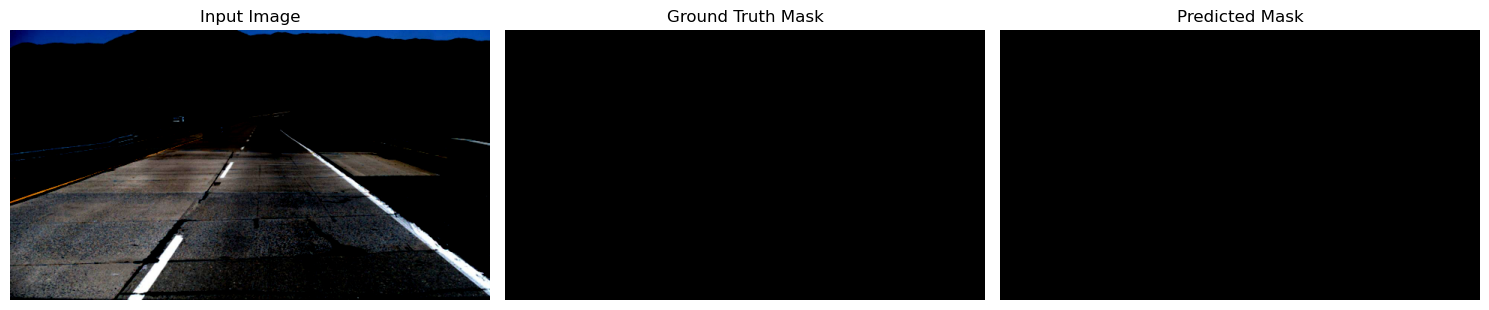

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9921569..1.0].


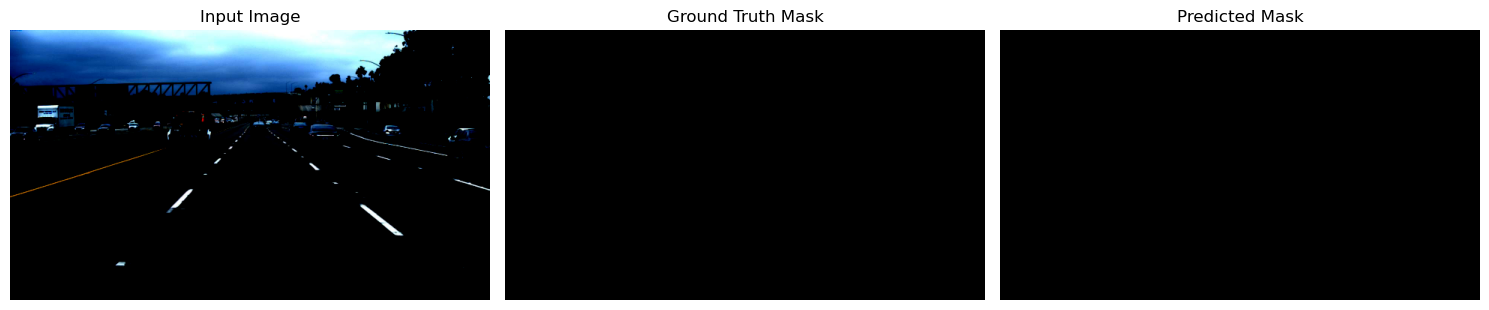

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.95294124..1.0].


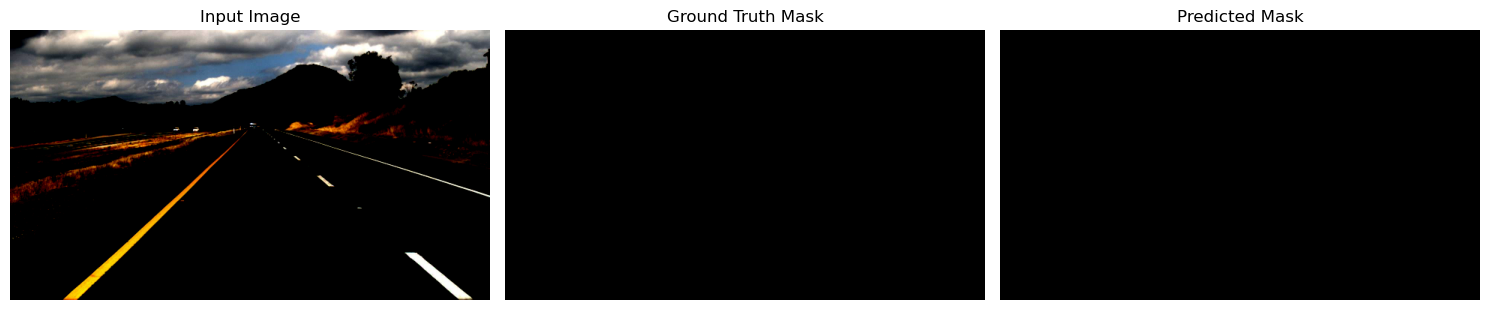

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


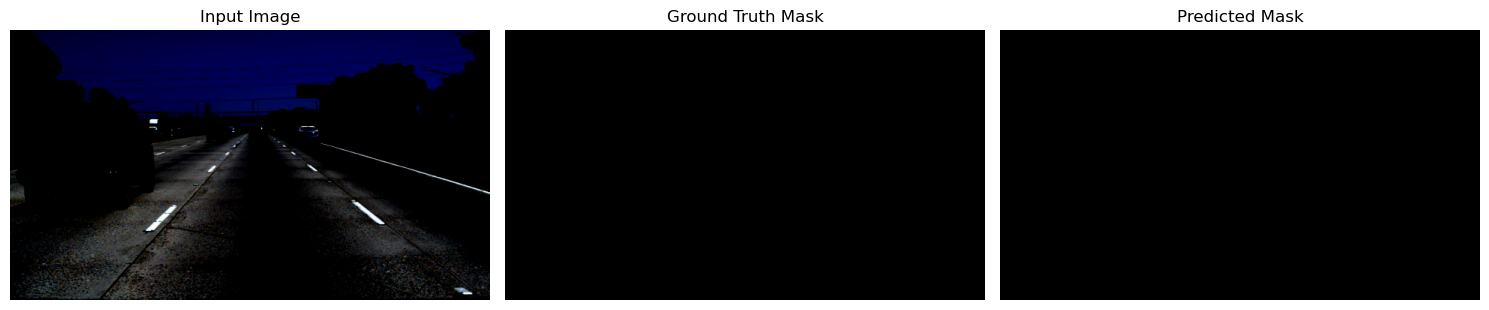

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9921569..0.8431373].


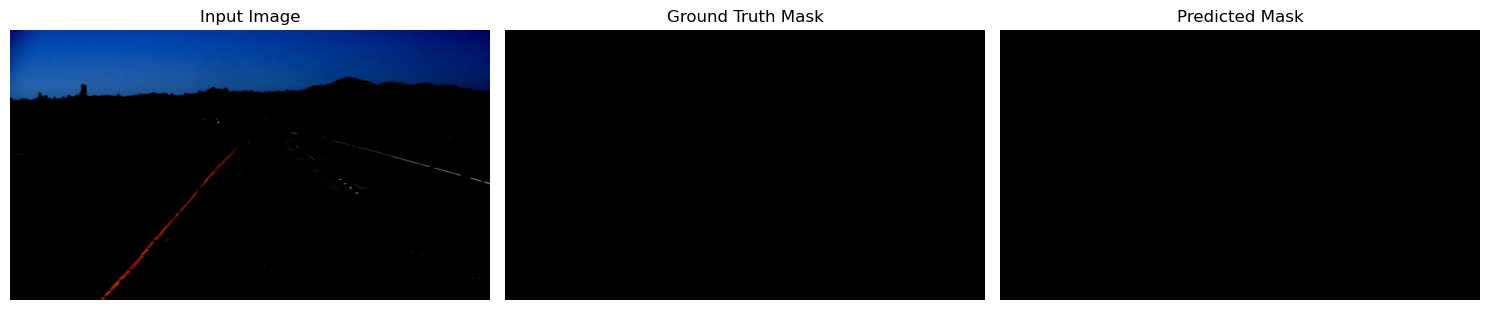

In [167]:
visualize_lane_predictions(model, test_dataset, device, num_samples=5)
